```
# download dataset
mkdir cats && cd cats && wget -i ../fancycats-images.links
mkdir dogs && cd dogs && wget -i ../fancydogs-images.links

# label all data
cd ../cats && for f in $(ls -1); do mv "$f" "cats.$f"; done
cd ../dogs && for f in $(ls -1); do mv "$f" "dogs.$f"; done
cd ..

# put into valid folders
mkdir -p test/unknown
mkdir -p train/cats
mkdir -p train/dogs
mkdir -p valid/cats
mkdir -p valid/dogs

# test 10% data
for f in $(ls -1 cats | head -n 100); do mv "cats/$f" test/unknown/; done
for f in $(ls -1 dogs | head -n 100); do mv "dogs/$f" test/unknown/; done

# validation 20% data
for f in $(ls -1 cats | head -n 200); do mv "cats/$f" valid/cats/; done
for f in $(ls -1 dogs | head -n 200); do mv "dogs/$f" valid/dogs/; done

# train 70% data
mv cats train/
mv dogs train/

```


In [1]:
%matplotlib inline

In [2]:
import glob
import numpy as np
import shutil
import os

In [3]:
DATA_PATH = "/home/ostap/courses/deeplearning1/nbs/data/fancy-cats-dogs/"
_TRAIN = "train/"
_VALID = "valid/"
_TEST = "test/"

In [4]:
from vgg16 import Vgg16

Using Theano backend.
/home/ostap/anaconda2/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7004 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:04.0)


In [5]:
path = DATA_PATH

In [6]:
vgg = Vgg16()

In [7]:
batch_size = 64
train_batches = vgg.get_batches(path + _TRAIN, batch_size=batch_size) # default batch_size = 8
val_batches = vgg.get_batches(path + _VALID, batch_size=batch_size)

Found 1400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [8]:
vgg.finetune(train_batches)

In [9]:
epoch_id = 1

In [10]:
for i in range(10):
    vgg.fit(train_batches, val_batches, nb_epoch=1)
    epoch_id = epoch_id + 1 # if we re-run this script, i still wanna have power over the ID
    vgg.model.save_weights(DATA_PATH + ("results/full_e%02d.h5" % epoch_id))

Epoch 1/1
1400/1400 [==============================] - 43s - loss: 0.5330 - acc: 0.8150 - val_loss: 0.0977 - val_acc: 0.9600
Epoch 1/1
1400/1400 [==============================] - 42s - loss: 0.1757 - acc: 0.9486 - val_loss: 0.0823 - val_acc: 0.9650
Epoch 1/1
1400/1400 [==============================] - 42s - loss: 0.1376 - acc: 0.9621 - val_loss: 0.0447 - val_acc: 0.9800
Epoch 1/1
1400/1400 [==============================] - 42s - loss: 0.0751 - acc: 0.9771 - val_loss: 0.0387 - val_acc: 0.9800
Epoch 1/1
1400/1400 [==============================] - 42s - loss: 0.0792 - acc: 0.9686 - val_loss: 0.0331 - val_acc: 0.9850
Epoch 1/1
1400/1400 [==============================] - 42s - loss: 0.0804 - acc: 0.9707 - val_loss: 0.0286 - val_acc: 0.9900
Epoch 1/1
1400/1400 [==============================] - 42s - loss: 0.0625 - acc: 0.9807 - val_loss: 0.0207 - val_acc: 0.9925
Epoch 1/1
1400/1400 [==============================] - 42s - loss: 0.0725 - acc: 0.9764 - val_loss: 0.0159 - val_acc: 0.9900


In [11]:
test_batches, predictions = vgg.test(path + _TEST)

Found 200 images belonging to 2 classes.


In [12]:
import utils; reload(utils)
from utils import plots, categories_to_onehot, plot_confusion_matrix

In [13]:
# labels in format [0, 1, 3, 3, 2, 1, 3] <-- the ID of the category. Length = number of samples.
result_labels = np.argmax(predictions, axis=1)
expected_labels = test_batches.classes

# arrays in onehot format [[1 0 0 0], [0 1 0 0], [0 0 0 1], ...]
# predictions # resulting predictions from the model
# expected_predictions = categories_to_onehot(test_batches.classes)

In [20]:
print result_labels[:5]
print expected_labels[:5]


[0 0 0 0 0]
[0 0 0 0 0]


In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, result_labels)

[[99  1]
 [ 2 98]]


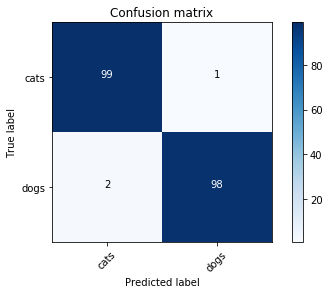

In [15]:
plot_confusion_matrix(cm, test_batches.class_indices)

[ 1.  0.]


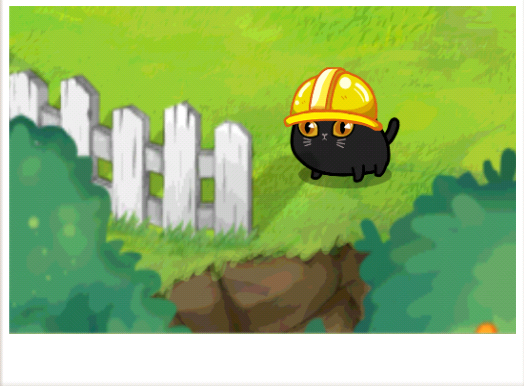

In [17]:
test_pred = 10
print np.round(predictions[test_pred],2)
from PIL import Image
Image.open(path + _TEST + test_batches.filenames[test_pred])

In [22]:
from keras.preprocessing import image
filenames = test_batches.filenames

In [23]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + _TEST + filenames[i]) for i in idx], titles=titles)
    

In [24]:
n_view = 4

In [25]:
print result_labels[:5]
print expected_labels[:5]


[0 0 0 0 0]
[0 0 0 0 0]


In [30]:
from numpy.random import permutation

Found 197 correct labels


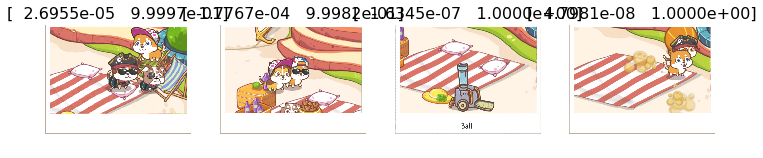

In [31]:
#1. A few correct labels at random
correct = np.where(result_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, predictions[idx])

Found 3 incorrect labels


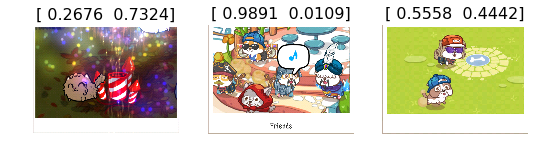

In [33]:
#2. A few incorrect labels at random
incorrect = np.where(result_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, predictions[idx])

In [65]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(predictions-0.5))
plots_idx(most_uncertain[:n_view], predictions[most_uncertain])

TypeError: only integer scalar arrays can be converted to a scalar index

In [61]:
np.concatenate([np.array([filenames]).T,predictions], axis=1)


array([['cats/cats.05bcdde21174a29841d216ce15a1b77f57f6bc511dd580209172d63025740dcf.png',
        '0.998308777809', '0.00169121683575'],
       ['cats/cats.04fb84738e717a39d03280c9227001404719dafa4555c16bdbc89808eba6257e.png',
        '0.951893568039', '0.0481064580381'],
       ['cats/cats.03bcb64362f40ccc248a1faf905107c6cfcd2b5b80bbeb0192d45f3b6a7623b2.png', '1.0',
        '2.85280137291e-08'],
       ['cats/cats.0aab0d0d4cd53edc1a8abb609dc04b17c5911b644b2b0b9b4fd40a672d466dfb.jpg',
        '0.999459326267', '0.000540710578207'],
       ['cats/cats.1223a6630981b62d8cbb1cc3eb8c0f3714e2f5c31a31733c4768ed554645eb41.png',
        '0.999959111214', '4.09034291806e-05'],
       ['cats/cats.0fdd8e3b792eba3fc8dbff2a3159d6d12fa28c5bd92eda23fed05b57be42286c.jpg',
        '0.999497056007', '0.000502913317177'],
       ['cats/cats.050123245d66ce8deb3ea3ab0ec850d3be67ebf82c12ac56589740a7afe54756.png',
        '0.999987721443', '1.233446892e-05'],
       ['cats/cats.09b020eb5241dd51e46ccedb8dee2dd

In [55]:
rounded_predictions[:4]

(array([[  9.9830e-01,   1.7000e-03],
        [  9.5190e-01,   4.8100e-02],
        [  1.0000e+00,   0.0000e+00],
        [  9.9950e-01,   5.0000e-04],
        [  1.0000e+00,   0.0000e+00],
        [  9.9950e-01,   5.0000e-04],
        [  1.0000e+00,   0.0000e+00],
        [  9.9620e-01,   3.8000e-03],
        [  9.9980e-01,   2.0000e-04],
        [  9.9990e-01,   1.0000e-04],
        [  1.0000e+00,   0.0000e+00],
        [  1.0000e+00,   0.0000e+00],
        [  1.0000e+00,   0.0000e+00],
        [  9.9920e-01,   8.0000e-04],
        [  1.0000e+00,   0.0000e+00],
        [  1.0000e+00,   0.0000e+00],
        [  1.0000e+00,   0.0000e+00],
        [  9.9920e-01,   8.0000e-04],
        [  1.0000e+00,   0.0000e+00],
        [  9.9960e-01,   4.0000e-04],
        [  1.0000e+00,   0.0000e+00],
        [  1.0000e+00,   0.0000e+00],
        [  9.9980e-01,   2.0000e-04],
        [  9.9990e-01,   1.0000e-04],
        [  9.9890e-01,   1.1000e-03],
        [  1.0000e+00,   0.0000e+00],
        [  9

In [60]:
print np.shape(np.array([filenames]).T)
print np.shape(predictions)


(200, 1)
(200, 2)
